In [1]:
# Steps made:

# 1. Divide the "celeba" dataset into batches of 100 imgs each.
#  -> We have batches 1,2,...,N

# 2. Generate augmented imgs from batch 1
#  -> parameters used (the models (3 types) and materials (5 types) are constant):
#       - poses: (yaw, pitch, roll) = ([-10,10,10],[-5,5,5],0)     # [-10,10,10] means values {-10,0,10}
#     so for each class, 9 images are generated from 1 img in the batch
#
#  -> 9*100 imgs for each class are available

# 3. Sort all augmented imgs to each of the 3*5 classes

# 4. For augmented imgs of each class, divide them into train,validation and test set
#  -> Decision: 80% train, 20% validation

# 5. Classifier:
#  -> Load pretrained CNN
#  (Method A)
#    - Method is "use output last conv layer as feature extractor"
#    - Then add new single fc layer which we train the to classify features to classes
#
#  (Method B)
#    - Method is "fine-tune all weights from all the layers of pretrained CNN"
#      on the training set
#

# Parameters: 
#

# 6.

# 7. Save trained classifier on disk

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# The CNN we use wants input dimensions of 3x224x224
#
# We use dataset of 2D faces where width x height is not 224x224
#  -> Rescale to 256 as first transformation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Data folder structure:
# /augmented_dataset
#   - /train
#       - /class_1
#       - /class_2
#   - /val
#       - /class_1
#       - /class_2
data_dir = 'augmented_data'
BATCH_SIZE = 3

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
image_datasets['train'].classes

['Enzo_glamourRed',
 'Enzo_goldPotato',
 'Enzo_lushGreen',
 'Enzo_obsidianBlack',
 'Enzo_tornadoBlue',
 'GerretLight_glamourRed',
 'GerretLight_goldPotato',
 'GerretLight_lushGreen',
 'GerretLight_obsidianBlack',
 'GerretLight_tornadoBlue',
 'HazzBerry_glamourRed',
 'HazzBerry_goldPotato',
 'HazzBerry_lushGreen',
 'HazzBerry_obsidianBlack',
 'HazzBerry_tornadoBlue']

In [5]:
for i,c in iter(dataloaders['train']):
    print(len(i))
    print(c)

3
tensor([ 0,  9,  7])
3
tensor([  7,  10,   6])
3
tensor([  7,   4,  13])
3
tensor([  1,  13,  13])
3
tensor([ 1,  8,  1])
3
tensor([ 11,   5,   4])
3
tensor([  1,  12,   8])
3
tensor([ 12,  11,   3])
3
tensor([  6,   8,  10])
3
tensor([  0,  12,   2])
3
tensor([ 6,  3,  4])
3
tensor([ 10,   5,   7])
3
tensor([  5,   9,  12])
3
tensor([ 2,  9,  7])
3
tensor([ 9,  3,  0])
3
tensor([ 4,  8,  0])
3
tensor([ 7,  3,  3])
3
tensor([ 11,  14,  14])
3
tensor([ 6,  8,  2])
3
tensor([ 11,  11,   7])
3
tensor([ 10,   0,   1])
3
tensor([ 2,  0,  1])
3
tensor([  2,  10,   0])
3
tensor([ 10,  14,  13])
3
tensor([ 14,  12,  10])
3
tensor([ 11,   1,  13])
3
tensor([ 2,  7,  8])
3
tensor([  3,  10,   2])
3
tensor([  6,   9,  14])
3
tensor([ 12,  13,   8])
3
tensor([ 8,  1,  6])
3
tensor([ 13,   2,   4])
3
tensor([ 13,  13,   3])
3
tensor([ 11,   3,   9])
3
tensor([  0,   5,  12])
3
tensor([  6,  11,   7])
3
tensor([  3,   6,  12])
3
tensor([  2,  10,   9])
3
tensor([  5,  12,   3])
3
tensor([  1,   6,

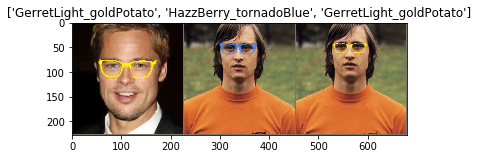

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
NUM_CLASSES = 25

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/aske/.torch/models/resnet18-5c106cde.pth
100.0%


In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)#25)

Epoch 0/4
----------
train Loss: 3.0094 Acc: 0.0698
val Loss: 2.4470 Acc: 0.2556

Epoch 1/4
----------
train Loss: 2.6775 Acc: 0.1587
val Loss: 2.0840 Acc: 0.3000

Epoch 2/4
----------
train Loss: 2.2816 Acc: 0.2698
val Loss: 2.0572 Acc: 0.2778

Epoch 3/4
----------
train Loss: 2.1592 Acc: 0.2698
val Loss: 1.8145 Acc: 0.3889

Epoch 4/4
----------
train Loss: 2.0447 Acc: 0.3206
val Loss: 1.7788 Acc: 0.3111

Training complete in 3m 4s
Best val Acc: 0.388889


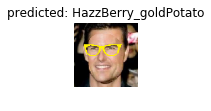

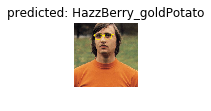

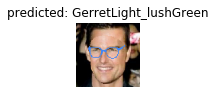

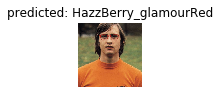

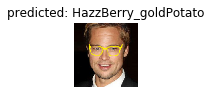

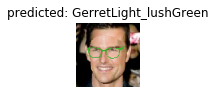

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [12]:
model_resnet18 = torchvision.models.resnet18(pretrained=True)
q = list(model_resnet18.parameters())

In [13]:
w = torch.Tensor(q[0].detac)

AttributeError: 'Parameter' object has no attribute 'detac'

In [ ]:
w

In [ ]:
w.shape

In [ ]:
inputs.shape

In [ ]:
aaa = torchvision.utils.make_grid(w)
#imshow(aaa)

In [ ]:
imshow(aaa)

In [ ]:
model_resnet18